Experiment 5.

Adopted from: https://colab.research.google.com/drive/120kYYBOVa1i0TD85RjlEkFjaWDxSFUx3?usp=sharing

In [1]:
#@title Defining a time-dependent score-based model (double click to expand or collapse)

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps."""
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None]


class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.embed(t))
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.act(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)
    h2 = self.gnorm2(h2)
    h2 = self.act(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)
    h3 = self.gnorm3(h3)
    h3 = self.act(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)
    h4 = self.gnorm4(h4)
    h4 = self.act(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)
    h = self.tgnorm4(h)
    h = self.act(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)
    h = self.tgnorm3(h)
    h = self.act(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)
    h = self.tgnorm2(h)
    h = self.act(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

In [2]:
#@title Set up the SDE
import functools
import torch
import numpy as np

device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}

def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:
      t: A vector of time steps.
      sigma: The $\sigma$ in our SDE.

    Returns:
      The standard deviation.
    """
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
      t: A vector of time steps.
      sigma: The $\sigma$ in our SDE.

    Returns:
      The vector of diffusion coefficients.
    """
    return torch.tensor(sigma**t, device=device)

sigma = 25.0 #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:26: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-592558538.py:13: SyntaxWarning: invalid escape sequence '\s'
  sigma: The $\sigma$ in our SDE.
/tmp/ipython-input-592558538.py:26: SyntaxWarning: invalid escape sequence '\s'
  sigma: The $\sigma$ in our SDE.


In [3]:
#@title Define the loss function (double click to expand or collapse)

def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

In [4]:
!wget https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tree.npy

--2025-09-15 11:23:50--  https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tree.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113461344 (108M) [application/octet-stream]
Saving to: ‘tree.npy’

tree.npy            100%[===================>] 108.21M  83.0MB/s    in 1.3s    

2025-09-15 11:23:51 (83.0 MB/s) - ‘tree.npy’ saved [113461344/113461344]



In [5]:
import os
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch
import numpy as np

output_dir = "denoising_process"
os.makedirs(output_dir, exist_ok=True)

data = np.load('tree.npy') # 784

# to 28x28 and normalize
raw_images = data.reshape(-1, 28, 28).astype(np.float32) / 255.0

# bg=0 and strokes=1, then invert again
# this makes bg=1 and strokes=0
images = 1.0 - raw_images
# convert to tensor and add channel dimension
images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1)

# use regular colormap
num_samples = 25
random_indices = torch.randperm(len(images_tensor))[:num_samples]
sample_images = images_tensor[random_indices]
grid = make_grid(sample_images, nrow=5, padding=2, pad_value=1.0) # white padding

plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray', vmin=0, vmax=1)
plt.axis('off')

# save
plt.savefig(os.path.join(output_dir, 'tree_dataset_samples.pdf'),
            bbox_inches='tight', dpi=300)
plt.close()

print(f"saved samples to {output_dir}/tree_dataset_samples.pdf")
print(f"total number of samples: {len(data)}")

saved samples to denoising_process/tree_dataset_samples.pdf
total number of samples: 144721


In [6]:
import torch
import numpy as np
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import tqdm
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import os


# load the bitmaps
data = np.load('tree.npy')

# Reshape to 28x28 and normalize
images = data.reshape(-1, 28, 28).astype(np.float32) / 255.0

# Convert to tensor and add channel dimension
images_tensor = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
dataset = TensorDataset(images_tensor) # use all

# output directory for plots
output_dir = "training_results"
os.makedirs(output_dir, exist_ok=True)

# Training code
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)
n_epochs = 60
batch_size = 32
lr = 1e-4
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

# losses for plotting
epoch_losses = []
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    for batch in data_loader:
        x = batch[0].to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    scheduler.step()
    epoch_loss = avg_loss / num_items
    epoch_losses.append(epoch_loss)

    # every 10 epochs or last epoch
    if (epoch + 1) % 10 == 0 or epoch == n_epochs - 1:
        print(f'epoch {epoch+1}/{n_epochs}: loss = {epoch_loss:.6f}')
    tqdm_epoch.set_description(f'average Loss: {epoch_loss:.5f}')
torch.save(score_model.state_dict(), 'ckpt_quickdraw_tree.pth')

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), epoch_losses, 'b-', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'training_loss_tree.pdf'),
            bbox_inches='tight', dpi=150)
plt.close()

print(f'initial loss: {epoch_losses[0]:.6f}')
print(f'final loss: {epoch_losses[-1]:.6f}')
print(f'loss reduction: {((epoch_losses[0] - epoch_losses[-1]) / epoch_losses[0] * 100):.2f}%')
print(f"training loss plot saved to {output_dir}/training_loss_octopus.pdf")

  0%|          | 0/60 [00:00<?, ?it/s]

/tmp/ipython-input-592558538.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


KeyboardInterrupt: 

In [7]:
#@title Define the Euler-Maruyama sampler (double click to expand or collapse)

## The number of sampling steps.
num_steps =  1000#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=128,
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
      #x = mean_x  # No noise added!

  # Do not include any noise in the last sampling step.
  return mean_x

In [9]:
# upload the checkpoint file from your PC
from google.colab import files
uploaded = files.upload()

Saving ckpt_quickdraw_tree.pth to ckpt_quickdraw_tree.pth


In [11]:
# to import checkpoints
score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# doad the saved weights
ckpt = torch.load('ckpt_quickdraw_tree.pth', map_location=device)
score_model.load_state_dict(ckpt)

# evaluation mode for sampling
score_model.eval()

DataParallel(
  (module): ScoreNet(
    (embed): Sequential(
      (0): GaussianFourierProjection()
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (dense1): Dense(
      (dense): Linear(in_features=256, out_features=32, bias=True)
    )
    (gnorm1): GroupNorm(4, 32, eps=1e-05, affine=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense2): Dense(
      (dense): Linear(in_features=256, out_features=64, bias=True)
    )
    (gnorm2): GroupNorm(32, 64, eps=1e-05, affine=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense3): Dense(
      (dense): Linear(in_features=256, out_features=128, bias=True)
    )
    (gnorm3): GroupNorm(32, 128, eps=1e-05, affine=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (dense4): Dense(
      (dense): Linear(in_features=256, out_features=256,

/tmp/ipython-input-592558538.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipython-input-592558538.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 1000/1000 [00:03<00:00, 299.00it/s]


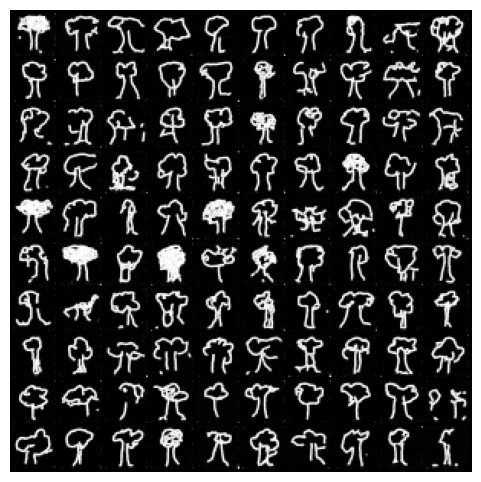

In [12]:
#@title Sampling (double click to expand or collapse)
from tqdm import tqdm
from torchvision.utils import make_grid

## Load the pre-trained checkpoint from disk.
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('ckpt_quickdraw_tree.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 100 #@param {'type':'integer'}
sampler = Euler_Maruyama_sampler #@param ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}

## Generate samples using the specified sampler.
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [14]:
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

def visualize_denoising_process_modified(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                         num_samples=4, device='cuda'):

    output_dir = "denoising_process"
    os.makedirs(output_dir, exist_ok=True)

    # init pure noise
    init_x = torch.randn(num_samples, 1, 28, 28, device=device) * marginal_prob_std_fn(torch.tensor(1.0, device=device))

    # time steps
    num_steps = 1000
    time_steps = torch.linspace(1., 1e-3, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]

    # save points
    save_at_steps = [0, 50, 100, 200, 250, 300, 400, 450, 500, 480, 499, 750, 800, 850, 950, 999]
    saved_samples = []

    x = init_x

    # reverse diffusion
    with torch.no_grad():
        for i, time_step in enumerate(tqdm(time_steps, desc="Denoising")):
            batch_time_step = torch.ones(num_samples, device=device) * time_step
            g = diffusion_coeff_fn(batch_time_step)

            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
            #x = mean_x

            # save at specified steps
            if i in save_at_steps:
                saved_samples.append(x.clamp(0.0, 1.0).cpu())

    # grid
    fig, axes = plt.subplots(num_samples, len(saved_samples),
                            figsize=(len(saved_samples)*1.5, num_samples*1.5))

    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        for j, samples in enumerate(saved_samples):
            ax = axes[i, j] if num_samples > 1 else axes[j]
            ax.imshow(samples[i, 0], cmap='gray_r', vmin=0, vmax=1)
            ax.axis('off')

            if i == 0:
                if j == 0:
                    ax.set_title('Noise', fontsize=9)
                elif j == len(saved_samples) - 1:
                    ax.set_title('Final', fontsize=9)
                else:
                    step_num = save_at_steps[j]
                    ax.set_title(f'Step {step_num}', fontsize=9)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'denoising_process_detailed.pdf'),
                bbox_inches='tight', dpi=150)
    plt.close()

    # a single row showing one example
    fig, axes = plt.subplots(1, len(saved_samples), figsize=(len(saved_samples)*1.5, 1.5))

    # the first sample to show
    sample_idx = 0
    for j, samples in enumerate(saved_samples):
        #axes[j].imshow(samples[sample_idx, 0], cmap='gray', vmin=0, vmax=1)
        axes[j].imshow(samples[sample_idx, 0], cmap='gray_r', vmin=0, vmax=1)
        axes[j].axis('off')
        if j == 0:
            axes[j].set_title('Noise', fontsize=10)
        elif j == len(saved_samples) - 1:
            axes[j].set_title('Final', fontsize=10)
        else:
            axes[j].set_title(f'Step {save_at_steps[j]}', fontsize=10)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'denoising_single_row_detailed.pdf'),
                bbox_inches='tight', dpi=150)
    plt.close()

    # saved frames (i used these for my thesis)
    key_steps = [0, 750, 850, 950, 999]
    fig, axes = plt.subplots(1, len(key_steps), figsize=(len(key_steps)*2, 2))

    for j, step in enumerate(key_steps):
        idx = save_at_steps.index(step)
        #axes[j].imshow(saved_samples[idx][sample_idx, 0], cmap='gray', vmin=0, vmax=1)
        axes[j].imshow(saved_samples[idx][sample_idx, 0], cmap='gray_r', vmin=0, vmax=1)
        axes[j].axis('off')
        #if j == 0:
            #axes[j].set_title('Pure Noise', fontsize=12)
        #elif j == len(key_steps) - 1:
            #axes[j].set_title('Final Sample', fontsize=12)
        #else:
            #axes[j].set_title(f'Step {step}/500', fontsize=12)

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'tree1.pdf'),
                bbox_inches='tight', dpi=300)
    plt.close()

visualize_denoising_process_modified(score_model, marginal_prob_std_fn, diffusion_coeff_fn,
                                    num_samples=4, device=device)

/tmp/ipython-input-592558538.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)
Denoising:   0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipython-input-592558538.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
Denoising: 100%|██████████| 1000/1000 [00:03<00:00, 329.41it/s]
